In [1]:
!pip -q install torchinfo

In [2]:
!pip freeze | grep torch
!pip freeze | grep torchinfo
!pip freeze | grep tensorboard

torch @ https://download.pytorch.org/whl/cu118/torch-2.1.0%2Bcu118-cp310-cp310-linux_x86_64.whl#sha256=a81b554184492005543ddc32e96469f9369d778dedd195d73bda9bed407d6589
torchaudio @ https://download.pytorch.org/whl/cu118/torchaudio-2.1.0%2Bcu118-cp310-cp310-linux_x86_64.whl#sha256=cdfd0a129406155eee595f408cafbb92589652da4090d1d2040f5453d4cae71f
torchdata==0.7.0
torchinfo==1.8.0
torchsummary==1.5.1
torchtext==0.16.0
torchvision @ https://download.pytorch.org/whl/cu118/torchvision-0.16.0%2Bcu118-cp310-cp310-linux_x86_64.whl#sha256=033712f65d45afe806676c4129dfe601ad1321d9e092df62b15847c02d4061dc
torchinfo==1.8.0
tensorboard==2.14.1
tensorboard-data-server==0.7.2


In [93]:
import numpy as np

import os

import torch
from torch import nn

# Get CPU or GPU device
DEVICE = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using {DEVICE} device')

from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

import torch.nn.functional as F

import matplotlib.pyplot as plt

import pandas as pd

from tqdm import tqdm

import time

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

Using cpu device


In [4]:
from IPython.display import display as d

In [73]:
from easydict import EasyDict

In [122]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  2
  On-line CPU(s) list:   0,1
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:          6
    Model:               79
    Thread(s) per core:  2
    Core(s) per socket:  1
    Socket(s):           1
    Stepping:            0
    BogoMIPS:            4399.99
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clf
                         lush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_
                         good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fm
                         a cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hyp
                         ervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd i

In [174]:
cfg = EasyDict()

cfg.dataset = EasyDict()

cfg.dataset.tmp_save_dir = "/content/train_model"

cfg.train = EasyDict()

cfg.train.batch_size = 128
cfg.train.num_workers = 1
cfg.train.learning_rate = 1e-3
cfg.train.scheduler_gamma = 0.99
cfg.train.scheduler_step_size = 10

cfg.model = EasyDict()

cfg.model.num_layers = 2
cfg.model.bidirectional = True
cfg.model.dropout_lstm = 0.0
cfg.model.dropout_gru = 0.0
cfg.model.num_embs = 12
cfg.model.hidden_size = 32

In [125]:
d(cfg)

{'dataset': {'tmp_save_dir': '/content/train_model'},
 'train': {'batch_size': 128,
  'num_workers': 1,
  'learning_rate': 0.001,
  'scheduler_gamma': 0.99,
  'scheduler_step_size': 10},
 'model': {'num_layers': 2,
  'bidirectional': True,
  'dropout_lstm': 0.0,
  'dropout_gru': 0.0,
  'num_embs': 12,
  'hidden_size': 64}}

# Imports

In [5]:
!pip -q install kaggle
!mkdir /root/.kaggle

In [6]:
!cp /content/drive/MyDrive/kaggle.json /root/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c spaceship-titanic

  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 94.5MB/s]


In [8]:
!unzip -q 'spaceship-titanic.zip' -d /content/spaceship_tmp

In [9]:
train = pd.read_csv('/content/spaceship_tmp/train.csv')
test = pd.read_csv('/content/spaceship_tmp/test.csv')

d(train)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


# Custom Dataset

In [175]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler

In [176]:
class DataConversion:

    def __init__(self, data: pd.DataFrame, test: bool = False):
        self.test = test

        data[['Deck', 'Num', 'Side']] = data['Cabin'].str.split('/', expand=True)

        if self.test:
            self.features = data.drop(['Cabin', 'Num', 'Name'], axis=1)
        else:
            self.targets = data['Transported'].replace({True: 1, False: 0})
            self.features = data.drop(['Cabin', 'Num', 'Name', 'Transported'], axis=1)

        self.features['Deck'] = self.features['Deck'].replace('T', 'G')

    @staticmethod
    def get_outliers(num_data: pd.DataFrame) -> pd.DataFrame:
        quantile_1 = num_data.quantile(0.01)
        quantile_3 = num_data.quantile(0.99)

        IQR = quantile_3 - quantile_1
        lower_cond = quantile_1 - 1.5 * IQR
        upper_cond = quantile_3 + 1.5 * IQR

        num_data = num_data[~((num_data < lower_cond) | (num_data > upper_cond))]

        return num_data

    def drop_encode(self):
        features = self.features.copy()

        num_cols = features.keys()[features.dtypes == 'float']
        features[num_cols] = SimpleImputer(strategy='median').fit_transform(features[num_cols])

        features[num_cols] = self.get_outliers(features[num_cols])
        features[num_cols] = StandardScaler().fit_transform(features[num_cols])

        cat_cols = features.keys()[features.dtypes != 'float']
        features[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(features[cat_cols])

        for key in cat_cols: features[key] = LabelEncoder().fit_transform(features[key])

        #features['Shop+Food'] = features['ShoppingMall'] + features['FoodCourt']

        if not self.test:
            df = features
            df['Transported'] = self.targets

        return features.dropna() if self.test else df.dropna()

In [177]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, data: pd.DataFrame, test: bool = False):
        self.test = test
        data_obj = DataConversion(data, test=self.test)

        data = data_obj.drop_encode()
        self.indices = data["PassengerId"].astype(int)

        self.targets = None if self.test else data[["Transported"]].set_index(self.indices)

        self.data = data.set_index(self.indices).drop(["PassengerId"], axis=1) if self.test else data.set_index(self.indices).drop(["PassengerId", "Transported"], axis=1)
        self.features_cols = self.data.keys()

    def shuffle_dataset(self) -> None:
        self.data = self.data.sample(frac=1)

    def __contains__(self, idx: int) -> bool:
        return True if idx in self.indices else False

    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int):
        if torch.is_tensor(idx): idx = idx.tolist()
        if self.__contains__(idx):
            return (dict(self.data.loc[idx])) if self.test else (dict(self.data.loc[idx]), dict(self.targets.loc[idx]))

In [178]:
%%time

train_data = CustomDataset(train.copy(), test=False)

CPU times: user 92.5 ms, sys: 4.75 ms, total: 97.2 ms
Wall time: 98.4 ms


In [179]:
LEN_DATA = len(train_data.data)

TRAIN_LEN = int(0.85 * LEN_DATA)

d(TRAIN_LEN)

7351

In [180]:
d(train_data.targets.value_counts())

Transported
1              4361
0              4288
dtype: int64

In [181]:
d(train_data.data)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Side
PassengerId,,,,,,,,,,,,
0,1,0,2,0.711945,0,-0.355711,-0.295466,-0.347787,-0.290965,-0.278064,1,0
1,0,0,2,-0.334037,0,-0.171799,-0.289331,-0.291785,0.267179,-0.235261,5,1
2,1,0,2,2.036857,1,-0.283159,2.142208,-0.347787,6.535875,-0.230397,0,1
3,1,0,2,0.293552,0,-0.355711,0.579124,0.483277,3.093480,-0.090316,0,1
4,0,0,2,-0.891895,0,0.155532,-0.247749,-0.009537,0.283446,-0.276118,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1,0,0,0.851410,1,-0.355711,4.352885,-0.347787,1.379400,-0.206078,0,0
8689,0,1,1,-0.752431,0,-0.355711,-0.295466,-0.347787,-0.290965,-0.278064,6,1
8690,0,0,2,-0.194573,0,-0.355711,-0.295466,3.845614,-0.289948,-0.278064,6,1


In [182]:
d(train_data.__getitem__(0))

({'HomePlanet': 1.0,
  'CryoSleep': 0.0,
  'Destination': 2.0,
  'Age': 0.7119453650967104,
  'VIP': 0.0,
  'RoomService': -0.35571114586949387,
  'FoodCourt': -0.29546639224910703,
  'ShoppingMall': -0.34778685333480236,
  'Spa': -0.29096452755373003,
  'VRDeck': -0.27806353877809287,
  'Deck': 1.0,
  'Side': 0.0},
 {'Transported': 0})

In [183]:
class CustomSequentialSampler(torch.utils.data.Sampler):

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return iter(self.indices)

    def __len__(self) -> int:
        return len(self.indices)

In [184]:
def custom_collate_fn(batch):
    features = dict(
        zip(
            train_data.features_cols, torch.stack([torch.as_tensor(list(item[0].values()), dtype=torch.float) for item in batch], dim=1)
        )
    )
    targets = {"Transported": torch.stack([torch.as_tensor(list(item[1].values()), dtype=torch.int64) for item in batch])}

    return features, targets

In [185]:
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=cfg.train.batch_size,
    collate_fn=custom_collate_fn,
    sampler=CustomSequentialSampler(train_data.indices.sample(frac=1)[:TRAIN_LEN]),
    num_workers=cfg.train.num_workers
)

valid_dataloader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=cfg.train.batch_size,
    collate_fn=custom_collate_fn,
    sampler=CustomSequentialSampler(train_data.indices[TRAIN_LEN:]),
    num_workers=cfg.train.num_workers
)

In [186]:
d(next(iter(valid_dataloader))[0].keys())

dict_keys(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Deck', 'Side'])

# Torch model


In [187]:
CAT_FEATURES = {col: len(train_data.data[col].unique()) for col in train_data.data.keys() if len(train_data.data[col].unique()) < 20}
NUM_FEATURES = [col for col in train_data.data.keys() if col not in CAT_FEATURES]

d(NUM_FEATURES, CAT_FEATURES)

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

{'HomePlanet': 3,
 'CryoSleep': 2,
 'Destination': 3,
 'VIP': 2,
 'Deck': 7,
 'Side': 2}

In [188]:
class SimpleAttention1d(nn.Module):

    def __init__(self, features_dim: int):
        super(SimpleAttention1d, self).__init__()
        self.features_dim = features_dim

        self.linear_block = nn.Sequential(
            nn.Linear(in_features=self.features_dim, out_features=self.features_dim),
            nn.BatchNorm1d(self.features_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return torch.multiply(inputs, self.linear_block(inputs))

In [189]:
class DenseFeatures(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, emb_dim: int = 10, bias: bool = True, num_layers: int = 1,
                 bidirectional: bool = False, dropout_lstm: float = 0.0, dropout_gru: float = 0.0, device: str = "cpu"):
        super(DenseFeatures, self).__init__()
        self.device = device

        self.embeddings = nn.ModuleDict()
        for col, num_embs in CAT_FEATURES.items():
            self.embeddings[col] = nn.Embedding(num_embeddings=num_embs, embedding_dim=emb_dim).to(self.device)

        self.layer_norm = nn.BatchNorm1d(num_features=input_size)
        self.att_layer = SimpleAttention1d(features_dim=input_size)

        num_directions = 2 if bidirectional else 1

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout_lstm
        ).to(self.device)

        self.gru = nn.GRU(
            input_size=hidden_size * num_directions,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout_gru
        )

        self.out = nn.Sequential(
            nn.Linear(in_features=hidden_size * num_directions, out_features=hidden_size, bias=bias),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout(p=0.2),

            nn.Linear(in_features=hidden_size, out_features=hidden_size // 2, bias=bias),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_size // 2),
            nn.Dropout(p=0.1),

            nn.Linear(in_features=hidden_size // 2, out_features=hidden_size // 4, bias=bias),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_size // 4),

            nn.Linear(in_features=hidden_size // 4, out_features=1, bias=bias)
        ).to(device)

    def forward(self, inputs: dict) -> torch.Tensor:
        x = torch.stack([inputs[col] for col in NUM_FEATURES], dim=1)

        for col in CAT_FEATURES:
            x = torch.concat([x, self.embeddings[col](torch.as_tensor(inputs[col], dtype=torch.int64))], dim=1)

        x = self.att_layer(self.layer_norm(x))

        x, (states_1, _) = self.lstm(x)
        x, _ = self.gru(x, states_1)

        return torch.sigmoid(self.out(x))

# Train

In [190]:
import time

class RNN:
    def __init__(self, train, valid, step_save: int = 100, reg_lambda: float = 1e-4):
        self.train_data = train
        self.valid_data = valid

        self.step_save = step_save

        self.model = DenseFeatures(
            input_size=len(CAT_FEATURES) * cfg.model.num_embs + len(NUM_FEATURES),
            hidden_size=cfg.model.hidden_size,
            dropout_lstm=cfg.model.dropout_lstm,
            dropout_gru=cfg.model.dropout_gru,
            emb_dim=cfg.model.num_embs,
            num_layers=cfg.model.num_layers,
            bidirectional=cfg.model.bidirectional,
            device=DEVICE
        )
        self.criterion = nn.BCELoss()

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=cfg.train.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=cfg.train.scheduler_step_size, gamma=cfg.train.scheduler_gamma)

        self.reg_lambda = reg_lambda

        self.train_results = list()
        self.valid_results = list()

        #if cfg.dataset.tmp_res_dir != "":
        #    os.mkdir(cfg.dataset.tmp_save_dir)

        #self.train_loss_writer = SummaryWriter("/content/train_model/logs/train")


    def save_model_params(self, save_epoch):
        torch.save(
            {
                "model": self.model.state_dict(),
                "optimizer": self.optimizer.state_dict(),
                "scheduler": self.scheduler.state_dict if self.scheduler is not None else {},
            }, "/content/train_model/model_state_dict_%d" % (self.step_save * (save_epoch + 1))
        )


    def fit(self, epochs: int = 3, show_step: int = 100):
        n_total_steps = TRAIN_LEN // BATCH_SIZE
        dataset_size = TRAIN_LEN

        save_epoch = 0

        for epoch in range(epochs):
            epoch_start_time = time.time()
            print('Epoch %s/%s' % (epoch + 1, epochs))

            n_correct = 0
            roc_auc_sum = 0

            for step, (inputs, labels) in enumerate(self.train_data):
                self.optimizer.zero_grad(set_to_none=True)
                #for param in self.model.parameters(): param.grad = None

                labels  = labels["Transported"].type(torch.float).to(DEVICE)

                output = self.model(inputs)

                n_correct += torch.sum(torch.round(output) == labels)
                roc_auc_sum += roc_auc_score(labels, output.detach().numpy())

                loss = self.criterion(output, labels) + self.reg_lambda * torch.sum(torch.stack([torch.square(torch.norm(weights, p=2)) for weights in self.model.parameters()]))

                loss.backward()
                self.optimizer.step()

                self.train_results.append([epoch * n_total_steps + step, loss.item(), roc_auc_score(labels, output.detach().numpy()), self.optimizer.param_groups[0]["lr"]])

                #self.train_loss_writer.add_scalar('training_loss', loss.item(), step)

                if (step+1) % show_step == 0:
                    print(f'Step [{step+1}/{n_total_steps}] | Time: {time.time() - epoch_start_time:.2f}s |  Loss: {loss.item():.4f}')

                self.scheduler.step()

                if (epoch * n_total_steps + step) % self.step_save == 0:
                    self.save_model_params(save_epoch)
                    save_epoch += 1

            print(f'{"-" * 60}\n{" " * 10}Accuracy/train: {n_correct.float() / dataset_size:.4f} | ROC-AUC/train: {roc_auc_sum / n_total_steps:.4f}\n{"-" *60}')
            self.valid(epoch)

            #self.train_data.shuffle_dataset()

        self.train_writer = pd.DataFrame(self.train_results, columns=["step", "loss", "roc_auc_score", "lr_value"])
        self.valid_writer = pd.DataFrame(self.valid_results, columns=["step", "loss", "roc_auc_score"])
        print('\nDone.')


    def valid(self, epoch):
        n_correct, loss_sum, roc_auc_sum = 0., 0., 0.

        n_total_steps = (LEN_DATA - TRAIN_LEN) // BATCH_SIZE
        dataset_size = LEN_DATA - TRAIN_LEN

        reg_loss = self.reg_lambda * torch.sum(torch.stack([torch.square(torch.norm(weights, p=2)) for weights in self.model.parameters()]))

        with torch.no_grad():
            for step, (inputs, labels) in enumerate(self.valid_data):
                labels = labels["Transported"].type(torch.float).to(DEVICE)

                output = self.model(inputs)

                n_correct += torch.sum(torch.round(output) == labels)
                roc_auc_sum += roc_auc_score(labels, output.detach().numpy())

                loss = self.criterion(output, labels).item()
                loss_sum += (loss + reg_loss)

            self.valid_results.append([(epoch + 1) * TRAIN_LEN // BATCH_SIZE, loss_sum / n_total_steps, roc_auc_sum / n_total_steps])

            print(f'{"-" * 60}\n{" " * 10}Accuracy/valid: {n_correct.float() / dataset_size:.4f} | ROC-AUC/valid: {roc_auc_sum / n_total_steps:.4f}\n{"-" *60}')


    def __repr__(self):
        return f'[INFO]\n{"-" * 60}\nmodel: {self.model} \n{"-" * 60} criterion: {self.criterion} \n{"-" * 60} \noptimizer: {self.optimizer} \n{"-" * 60}'

In [197]:
train_model = RNN(
    train=train_dataloader,
    valid=valid_dataloader,
    step_save=200,
    reg_lambda=1e-3
)
train_model.fit(epochs=15, show_step=15)

Epoch 1/15
Step [15/57] | Time: 3.56s |  Loss: 2.0300
Step [30/57] | Time: 6.80s |  Loss: 1.8587
Step [45/57] | Time: 11.33s |  Loss: 1.7509
------------------------------------------------------------
          Accuracy/train: 0.5050 | ROC-AUC/train: 0.5658
------------------------------------------------------------
------------------------------------------------------------
          Accuracy/valid: 0.5932 | ROC-AUC/valid: 0.6433
------------------------------------------------------------
Epoch 2/15
Step [15/57] | Time: 3.39s |  Loss: 1.5642
Step [30/57] | Time: 7.09s |  Loss: 1.4696
Step [45/57] | Time: 12.19s |  Loss: 1.4176
------------------------------------------------------------
          Accuracy/train: 0.5821 | ROC-AUC/train: 0.6368
------------------------------------------------------------
------------------------------------------------------------
          Accuracy/valid: 0.6333 | ROC-AUC/valid: 0.7418
------------------------------------------------------------
Ep

In [ ]:
#!rm -r -f /content/train_model
#!mkdir -p /content/train_model

In [198]:
!ls /content/train_model

model_state_dict_1000  model_state_dict_400  model_state_dict_800
model_state_dict_200   model_state_dict_600


In [199]:
d(train_model.valid_writer)

,step,loss,roc_auc_score
0,57,tensor(1.7949),0.643337
1,114,tensor(1.4805),0.741809
2,172,tensor(1.3094),0.787855
3,229,tensor(1.1598),0.885117
4,287,tensor(1.0518),0.936618
5,344,tensor(0.9818),0.960714
6,402,tensor(0.9471),0.960955
7,459,tensor(0.9115),0.968056
8,516,tensor(0.8903),0.964623
9,574,tensor(0.8857),0.957829


In [200]:
d(train_model.train_writer)

,step,loss,roc_auc_score,lr_value
0,0,2.175350,0.464751,0.001000
1,1,2.186869,0.485049,0.001000
2,2,2.162018,0.515018,0.001000
3,3,2.130700,0.556866,0.001000
4,4,2.113795,0.546432,0.001000
...,...,...,...,...
865,851,0.643053,0.928205,0.000421
866,852,0.658928,0.925871,0.000421
867,853,0.704807,0.893842,0.000421
868,854,0.707705,0.902581,0.000421


In [201]:
model_training_values = train_model.train_writer
model_valid_values = train_model.valid_writer

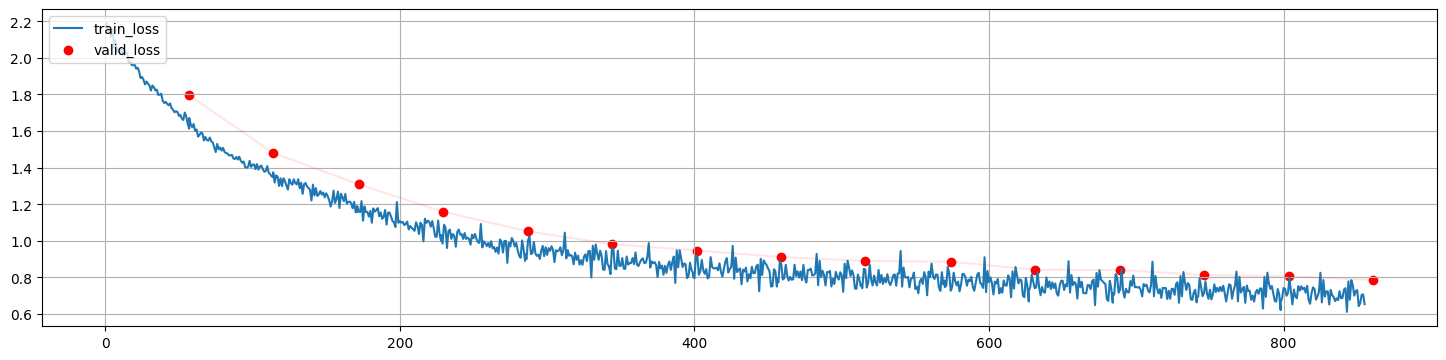

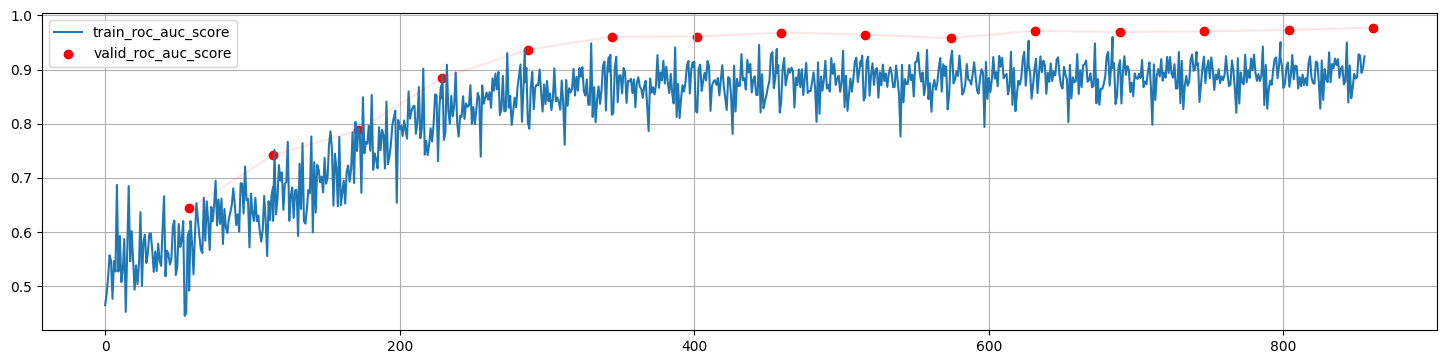

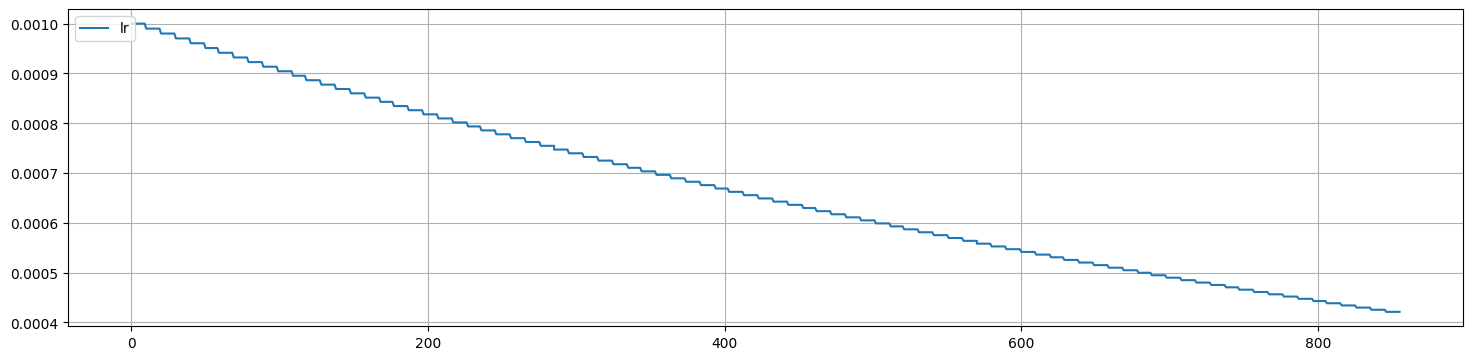

In [202]:
plt.figure(figsize=(18, 14)).add_subplot(3, 1, 1)
plt.grid()
plt.plot(model_training_values["step"], model_training_values["loss"], label="train_loss")
plt.scatter(model_valid_values["step"], model_valid_values["loss"], c="r", label="valid_loss")
plt.plot(model_valid_values["step"], model_valid_values["loss"], c="r", alpha=0.1)
plt.legend(loc=2)

plt.figure(figsize=(18, 14)).add_subplot(3, 1, 2)
plt.grid()
plt.plot(model_training_values["step"], model_training_values["roc_auc_score"], label="train_roc_auc_score")
plt.scatter(model_valid_values["step"], model_valid_values["roc_auc_score"], c="r", label="valid_roc_auc_score")
plt.plot(model_valid_values["step"], model_valid_values["roc_auc_score"], c="r", alpha=0.1)
plt.legend(loc=2)

plt.figure(figsize=(18, 14)).add_subplot(3, 1, 3)
plt.grid()
plt.plot(model_training_values["step"], model_training_values["lr_value"], label="lr")
plt.legend(loc=2)

# Scoring

In [218]:
def scoring(data, model, test: bool = False):
    with torch.no_grad():
        scores = []
        true_labels = []

        if test:
            for inputs in tqdm(data, desc='Scoring data...', ncols=80):
                output = model(inputs)
                scores.append(output)
        else:
            for (inputs, labels) in tqdm(data, desc='Scoring data...', ncols=80):
                labels = labels["Transported"].squeeze().to(DEVICE)

                output = model(inputs)

                scores.append(output)
                true_labels.append(labels)

        scores = torch.concatenate(scores)

        return pd.DataFrame(scores.detach().cpu(), columns=["proba"]) if test else (pd.DataFrame(scores.detach().cpu(), columns=["proba"]), torch.concatenate(true_labels))

In [205]:
test_data = CustomDataset(test.copy(), test=True)
d(test_data.data)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Side
PassengerId,,,,,,,,,,,,
0,0,1,2,-0.114147,0,-0.372440,-0.302025,-0.340179,-0.287303,-0.272034,6,1
1,0,0,2,-0.684313,0,-0.372440,-0.295362,-0.340179,2.632961,-0.272034,5,1
2,1,1,0,0.170937,0,-0.372440,-0.302025,-0.340179,-0.287303,-0.272034,2,1
3,1,0,2,0.669832,0,-0.372440,4.622172,-0.340179,-0.100067,0.303053,2,1
4,0,0,2,-0.613042,0,-0.354766,-0.302025,0.987321,-0.287303,-0.272034,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0,1,2,0.384749,0,-0.372440,-0.302025,-0.340179,-0.287303,-0.272034,6,1
4273,0,0,2,0.954916,0,-0.372440,0.324974,-0.304639,-0.276959,-0.130474,5,1
4274,2,1,0,-0.185417,0,-0.372440,-0.302025,-0.340179,-0.287303,-0.272034,3,0


In [206]:
def custom_test_collate_fn(batch):
    return dict(
        zip(
            test_data.features_cols, torch.stack([torch.as_tensor(list(item.values()), dtype=torch.float) for item in batch], dim=1)
        )
    )

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE*4,
    collate_fn=custom_test_collate_fn,
    sampler=CustomSequentialSampler(test_data.indices)
)

In [230]:
train_scores, true_labels = scoring(train_dataloader, train_model.model)

valid_scores, true_labels_valid = scoring(valid_dataloader, train_model.model)

test_scores = scoring(test_dataloader, train_model.model, test=True)

Scoring data...: 100%|████████████████████████████| 9/9 [00:01<00:00,  6.58it/s]


In [231]:
d(train_scores.mean(), valid_scores.mean(), test_scores.mean())

proba    0.49998
dtype: float32

proba    0.49893
dtype: float32

proba    0.495251
dtype: float32

In [232]:
def roc_curve(y_true, probas, class_weight = None):
    assert len(np.unique(y_true)) == 2, 'roc_auc for binary, sorry :('
    assert len(y_true) == len(probas), 'y_true and probas must have the same length'

    sorted_indices = np.argsort(probas)[::-1]

    y_true_sort, probas_sort = y_true[sorted_indices], probas[sorted_indices]

    num_positive = np.sum(y_true == 1)
    num_negative = np.sum(y_true == 0)

    class_weight = class_weight if class_weight is not None else num_negative / num_positive
    weights = np.where(y_true == 1, class_weight, 1.0)[sorted_indices]

    tp, fp = 0, 0
    tpr_values, fpr_values = [], []

    for i, label in enumerate(y_true_sort):
        if label == 1: tp += weights[i]
        else: fp += weights[i]

        tpr = tp / (num_positive * class_weight)
        fpr = fp / num_negative
        tpr_values.append(tpr)
        fpr_values.append(fpr)

    return tpr_values, fpr_values

In [233]:
tpr_train, fpr_train = roc_curve(true_labels.numpy(), train_scores.values.ravel())
tpr_valid, fpr_valid = roc_curve(true_labels_valid.numpy(), valid_scores.values.ravel())

roc_auc_score train: 0.8938
roc_auc_score valid: 0.8837

accuracy_train: 0.8135
accuracy_train: 0.7943



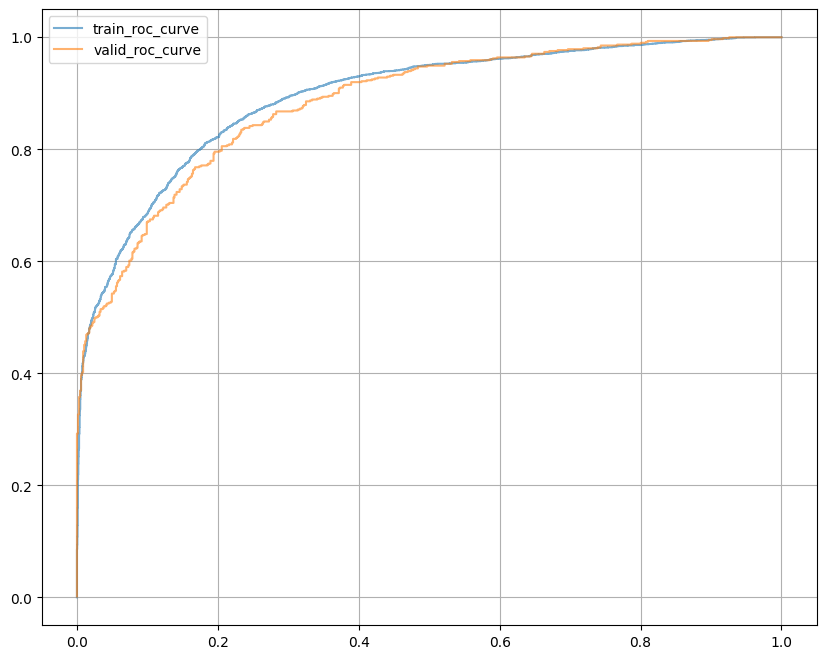

In [234]:
ax = plt.figure(figsize=(10, 8)).add_subplot()
print("roc_auc_score train: %.4f" % np.trapz(tpr_train, fpr_train))
print("roc_auc_score valid: %.4f\n" % np.trapz(tpr_valid, fpr_valid))

print("accuracy_train: %.4f" % (torch.sum(torch.from_numpy(train_scores.values.ravel()).round() == true_labels) / len(true_labels)).numpy())
print("accuracy_train: %.4f\n" % (torch.sum(torch.from_numpy(valid_scores.values.ravel()).round() == true_labels_valid) / len(true_labels_valid)).numpy())

ax.plot(fpr_train, tpr_train, alpha=0.6, label='train_roc_curve')
ax.plot(fpr_valid, tpr_valid, alpha=0.6, label='valid_roc_curve')
ax.grid()
ax.legend(loc=2)
plt.show();